# COMP3222/6246 Machine Learning Technologies (2023/24)
# Lab 5 – Perceptrons, Deep Net, and Convolutional Neural Net

In this lab, we introduce how to implement a perceptron, a deep neural network (DNN) and also a convolutional neural network (CNN). We also present you with a code that is working, but yields poor results. We expect you to spot the issues and improve the code. Exercises are also provided at the end of each section to improve your technical skill.

## Setup

_Make sure that the following code is executed before every other sections of this lab_

In [1]:
# Common imports
import os
import numpy as np

import tensorflow as tf
tf.__version__

# To plot nice figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Clear tensorflow's and reset seed
def reset_graph(seed=None):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

## A Perceptron

In this section, we will use an artificial neuron (aka _perceptron_) to perform binary classification on linearly separable data. Specifically, we will use a portion of the Iris dataset; the description of this dataset can be found at <a href="http://scikit-learn.org/stable/datasets/index.html#iris-dataset">http://scikit-learn.org/stable/datasets/index.html#iris-dataset</a>.

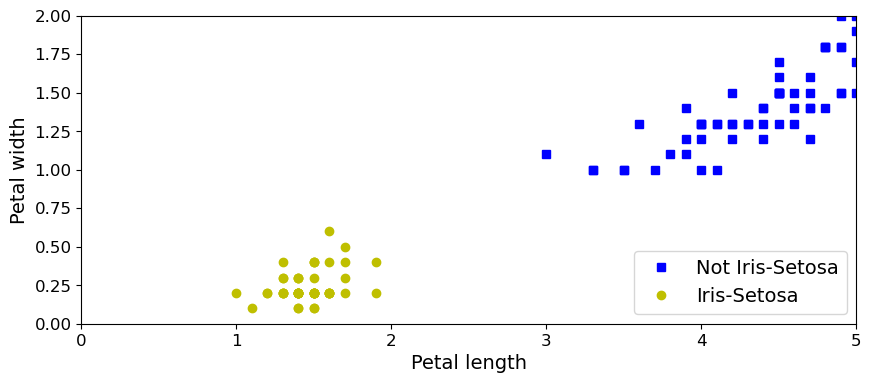

In [2]:
from sklearn.datasets import load_iris

# get dataset
iris = load_iris()
X = iris.data[:, (2, 3)]  # use only petal length and petal width
y = (iris.target == 0).astype(int) # classify them as either setosa or not setosa

# visualise the data
axes = [0, 5, 0, 2]
plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)
plt.show()

Clearly, this task can be easily done by using a linear classifier. Could you visualise the linear decision boundary on the figure above? Where should it be?

Now, let's move on to implementing a perceptron by using Scikit-learn.

In [12]:
from sklearn.linear_model import Perceptron

# initialise and train a perceptron
pct = Perceptron(max_iter=100, random_state=None)
pct.fit(X, y)

Perceptron(max_iter=100, random_state=None)

Notice that there are many parameters that you can tweak here. You can have a look at the description of each parameter in the Scikit-Learn's documentation <a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html">http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html</a>

Next, we will extract the decision boundary from the model. Below we show a general way of extracting a decision boundary with any model. Note that it can be very computationally expensive if the feature space is large.

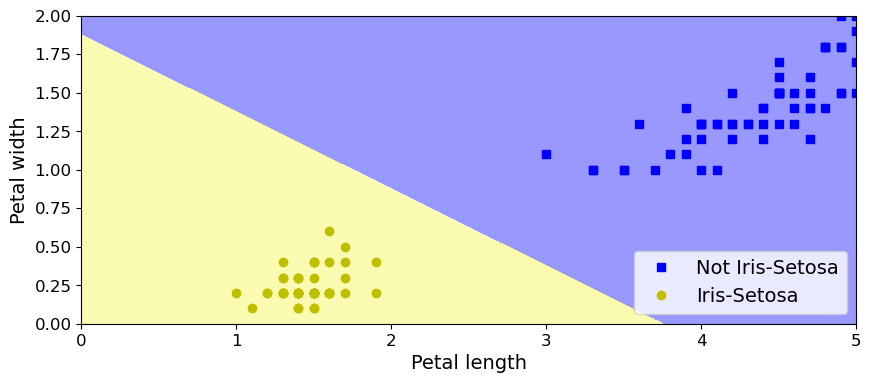

In [14]:
# sampling and predict the whole space of features
x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 10000).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 10000).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = pct.predict(X_new)
zz = y_predict.reshape(x0.shape)

# plot the datapoints again
plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

# get a nice color
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

# plot the predicted samples of feature space
plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)
plt.show()

**_Exercise 1_**
1. The decision boundary of a single perceptron is a single straight line, but the above plot shows differently! Fix this plot. (_Hint_: you need to sample the feature space more. Change the parameter of `np.linspace` above to generate more points. Have a look at the documentation: https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html.)

2. Try running the code in [3] and [4] multiple times; two snippets above where a network is initialised, trained, and plotted. Do you always get the same decision boundary? Why?
Depends on the random state we initialize at.

## Activation Functions

There are many activation functions that can be used in a perceptron. Different functions result in different behaviours, and consequently different pros & cons. Though we will not go into details, it is beneficial for you to know some popular activation functions.

$$ \text{heaviside} (z) = \begin{cases} 1 & \quad \text{if } z >= 0 \\ 0 & \quad \text{otherwise} \end{cases} $$

$$ \text{logit} (z) = \frac{1}{1 + e^{-z}} $$

$$ \text{relu} (z) = \max{\left( 0 , z \right)} $$

$$ \text{leaky_relu} (z, \alpha) = \max{\left( \alpha z , z \right)} $$

$$ \text{elu} (z, \alpha) = \begin{cases} \alpha \left( e^z - 1 \right) & \quad \text{if } z < 0 \\ z & \quad \text{otherwise} \end{cases} $$

**_Exercise 2_** 
Complete the cell below with the code for the activation functions listed (see equations). Note that they must be able to process NumPy arrays as well.

In [32]:
def heaviside(z): 
    return (z >= 0).astype(z.dtype)

def logit(z): # modify this function. Hint: Use np.exp()
    return (1 / (1 + np.exp(-z))).astype(z.dtype)

def relu(z): # modify this function. Hint: Use np.maximum()
    return np.maximum([0],[z])[0]

def leaky_relu(z, alpha=0.01): # modify this function and set default alpha to 0.01
    return (np.maximum([alpha * z],[z])[0]).astype(z.dtype)

def elu(z, alpha=1): # No need to modify this function!
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, # No need to modify this function!
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * elu(z, alpha)

Now we plot these different activation functions using the code below.

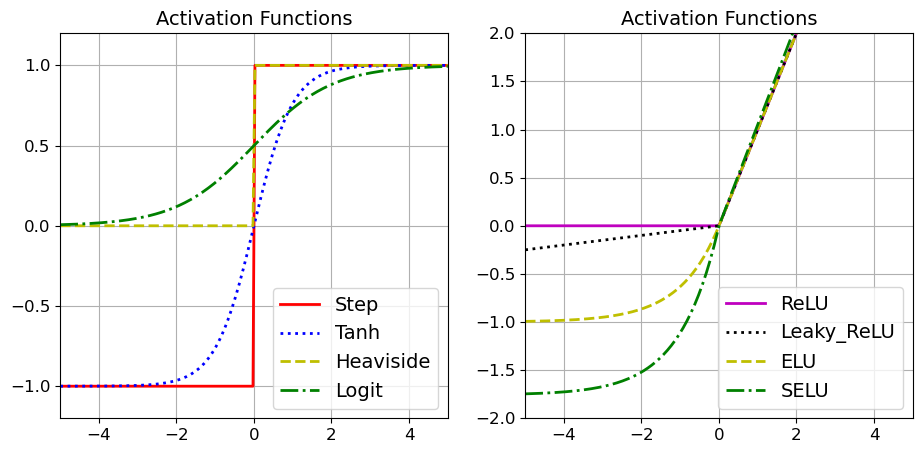

In [33]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,11))

plt.subplot(221)
plt.plot(z, np.sign(z), "r-", linewidth=2, label="Step")
plt.plot(z, np.tanh(z), "b:", linewidth=2, label="Tanh")
plt.plot(z, heaviside(z), "y--", linewidth=2, label="Heaviside")
plt.plot(z, logit(z), "g-.", linewidth=2, label="Logit")
plt.grid(True)
plt.legend(loc="lower right", fontsize=14)
plt.title("Activation Functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(222)
plt.plot(z, relu(z), "m-", linewidth=2, label="ReLU")
plt.plot(z, leaky_relu(z, 0.05), "k:", linewidth=2, label="Leaky_ReLU")
plt.plot(z, elu(z), "y--", linewidth=2, label="ELU")
plt.plot(z, selu(z), "g-.", linewidth=2, label="SELU")
plt.grid(True)
plt.legend(loc="lower right", fontsize=14)
plt.title("Activation Functions", fontsize=14)
plt.axis([-5, 5, -2, 2])

plt.show()

You should be able to see the following characteristics from the graph:
- Step function and Heaviside function are quite similar except for their output ranges.
- Similarly, the hyperbolic tangent and the logit/sigmoidal function are nearly the same except for their output ranges.
- Lastly, all variants of ReLU functions behave differently only when the input sum of a perceptron is lower than zero.

Note that different functions have different sensitivity to the perceptron input.

## (Deeper) Neural Net for MNIST on TensorFlow

In this section, we will construct and train a _deeper_ neural network with TensorFlow to perform classification. To train a large number of neurons, we would generally need a large dataset. So we will use MNIST (https://keras.io/api/datasets/mnist/) from now on. Keras API provides some utility functions to fetch and load some common datasets like MNIST. 

In [34]:
# Load MNIST
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

#We will also create validation set. Further, we #scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

11490434/11490434 [==============================] - 1s 0us/step


You can plot an image using Matplotlib's `imshow()` function, with a 'binary' color map.

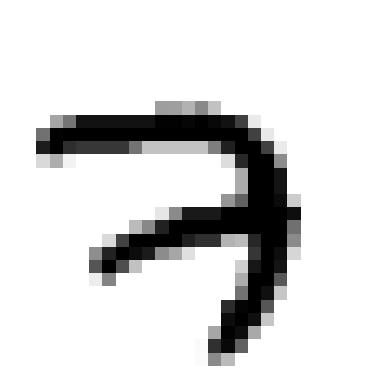

In [35]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

Remember the `Sequential API` that we used earlier? We will now use it to build a DNN with hidden layers as follows.

In [68]:
model = tf.keras.models.Sequential()

#Designing model with two hidden layers and an output layer
model.add(tf.keras.layers.Flatten(input_shape=[28,28]))
model.add(tf.keras.layers.Dense(200,activation="relu"))
model.add(tf.keras.layers.Dense(50,activation="relu"))
model.add(tf.keras.layers.Dense(10,activation="softmax"))


You can use methods such as `model.summary()` or `model.layers()` to retrieve the details of the network defined above. See documentation: https://www.tensorflow.org/api_docs/python/tf/keras/Model

To train this network, we need to define a loss function and choose an optimiser. The `model.compile()` method will be used to specify the loss function and the optimiser we want to use.

In [69]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

model.compile(loss=loss_fn,
              optimizer="adam",
              metrics=["accuracy"])


The model can be trained now. We simply need to use `model.fit()` method.

In [70]:
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_valid, y_valid))

Epoch 1/15
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2438 - accuracy: 0.9281 - val_loss: 0.1262 - val_accuracy: 0.9594
Epoch 2/15
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1069 - accuracy: 0.9686 - val_loss: 0.0989 - val_accuracy: 0.9682
Epoch 3/15
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0751 - accuracy: 0.9783 - val_loss: 0.0794 - val_accuracy: 0.9752
Epoch 4/15
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0583 - accuracy: 0.9831 - val_loss: 0.0877 - val_accuracy: 0.9762
Epoch 5/15
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0466 - accuracy: 0.9865 - val_loss: 0.0738 - val_accuracy: 0.9780
Epoch 6/15
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0387 - accuracy: 0.9890 - val_loss: 0.0825 - val_accuracy: 0.9792
Epoch 7/15
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0317 - accuracy: 0.9911 - val_loss: 0.1065 - val_accuracy:

In [ ]:
MSE, 300/100/10, relu/relu/softmax, sgd, 30 epoch --- val_loss: 27.3189 - val_accuracy: 0.0796
SparseCategoricalEntropy, 300/100/10, relu/relu/softmax, sgd, 30 epoch --- val_loss: 0.0675 - val_accuracy: 0.9816
SparseCategoricalEntropy, 200/50/10, relu/relu/softmax, sgd, 20 epoch --- val_loss: 0.0792 - val_accuracy: 0.9772
SparseCategoricalEntropy, 200/50/10, relu/relu/softmax, adam, 20 epoch --- val_loss: 0.1205 - val_accuracy: 0.9814

Rerun the cell above multiple times to see how accurate our trained model is. You should be able to see that the resulted accuracy is very low and our training is slightly time-consuming. 

**_Exercise 4_**
Modify and tune the neural net such that the training time is reduced but the accuracy is still acceptably high. You should try the following:
- MSE Loss is a poor choice for a classification task with fixed number of categories. Try using a loss function suitable for multi-class classification such as `categorical_sparse_entropy` loss. See documentation: https://keras.io/api/losses/
- Change the structure of the network by adding/removing a hidden layer or increasing/reducing number of neurons.
- Change the activation function of the hidden layers.
- Choose different optimisation algorithms such as `adam` or `RMSprop`. See documentation: https://keras.io/api/optimizers/

Do you observe any effect on the accuracy during the tuning? What is the best model that you can achieve?
Categorical Sparse Entropy had a huge effect
All other improvements for speed (changing activation didn't have much effect)

## Convolutional Neural Network (CNN) with TensorFlow

We now move on to convolutional neural net (CNN). The idea behind this architecture originated from a study on the animal visual cortex.We start with a simple exercise to understand convolution. 

Using `sklearn`, we load two sample images and carry out some basic convolution operations.

We also create two $7\times7$ filters, one with a vertical line in the middle and the other with a horizontal line in the middle.

We use `tf.nn.conv2d()` to perform the convolution operation. It requires the following inpus: images, filters and padding. `padding` must be either "SAME" or "VALID". "SAME" - convolutional layer uses zero padding if necessary so that the layer's output has the same dimensions as the input. "VALID" - doesn't use zero padding but instead, may ignore some rows and columns at the bottom and right of the input, depending on the stride.


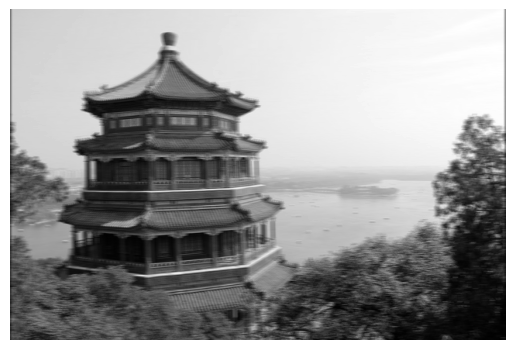

In [71]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off") 
plt.show()

In [72]:
# To plot figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

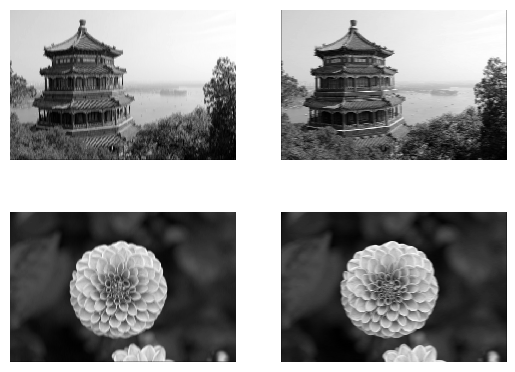

In [73]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

Saving figure china_original


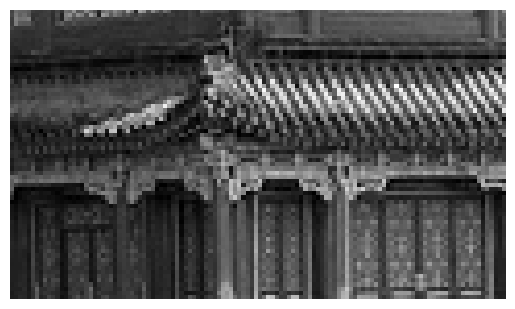

Saving figure china_vertical


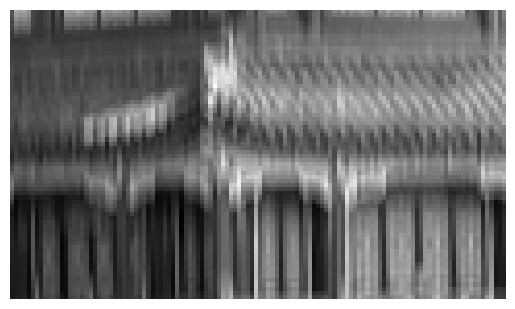

Saving figure china_horizontal


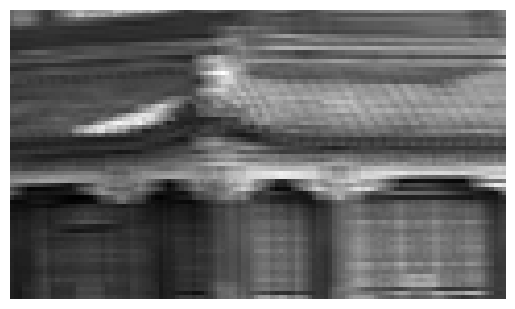

In [74]:
def crop(images):
    return images[150:220, 130:250]

plot_image(crop(images[0, :, :, 0]))
save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

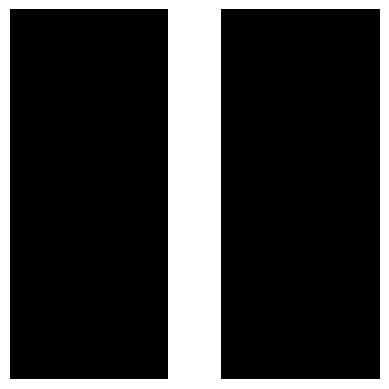

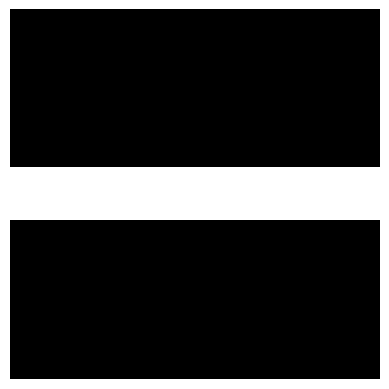

In [75]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

Let's create a 2D convolutional layer, using `tf.keras.layers.Conv2D()`

In [83]:
np.random.seed(42)
tf.random.set_seed(42)

conv = tf.keras.layers.Conv2D(filters=2, kernel_size=7, strides=1,
                           padding="SAME", activation="relu", input_shape=outputs.shape)

Calling this layer to passing the two test images into it.

In [84]:
conv_outputs = conv(images)
conv_outputs.shape 

TensorShape([2, 427, 640, 2])

The output is a 4D tensor. The dimensions are: batch size, height, width, channels. The first dimension (batch size) is 2 since there are 2 input images. The next two dimensions are the height and width of the output feature maps: since padding="SAME" and strides=1, the output feature maps have the same height and width as the input images (in this case, 427×640). Lastly, this convolutional layer has 2 filters, so the last dimension is 2: there are 2 output feature maps per input image.

Since the filters are initialized randomly, they will initially detect random patterns. Let us take a look at the 2 output features maps for each image:

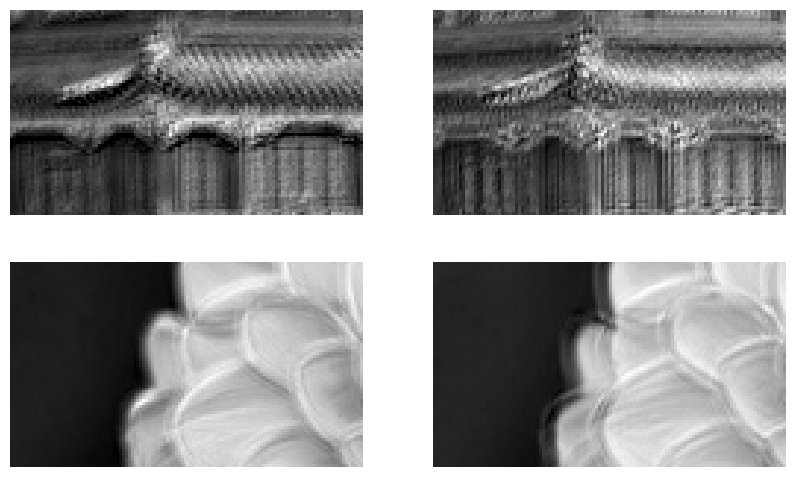

In [85]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

Although the filters were initialized randomly, the second filter happens to act like an edge detector. Randomly initialized filters often act this way, which is quite fortunate since detecting edges is quite useful in image processing.

If we want, we can set the filters to be the ones we manually defined earlier, and set the biases to zeros (in real life we will almost never need to set filters or biases manually, as the convolutional layer will just learn the appropriate filters and biases during training):

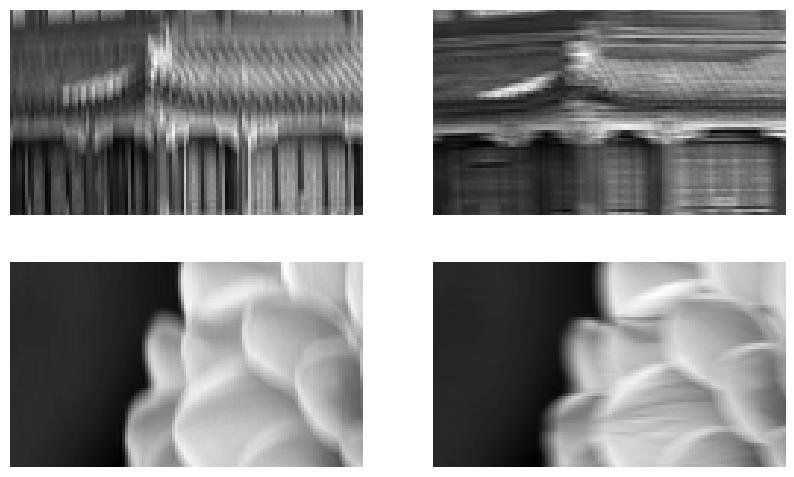

In [86]:
conv.set_weights([filters, np.zeros(2)])

conv_outputs = conv(images)
conv_outputs.shape 

plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

In [87]:
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding == "SAME":
        return (input_size - 1) // strides + 1
    else:
        return (input_size - kernel_size) // strides + 1
    
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width  = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images

In [88]:
kernel_size = 7
strides = 2

conv_valid = tf.keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
conv_same = tf.keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

# Need to call build() so conv_same's weights get created
conv_same.build(tf.TensorShape(images.shape))

# Copy the weights from conv_valid to conv_same
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())

## Pooling Layer

Pooling Layers are the second common building block of CNNs. They subsample the input image to reduce the computational load, memory usage and number of paramters, thereby limiting the risk of overfitting. Here, we create a Max Pooling using `tf.keras.layers.MaxPool2D`

In [89]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

In [90]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

Saving figure china_max_pooling


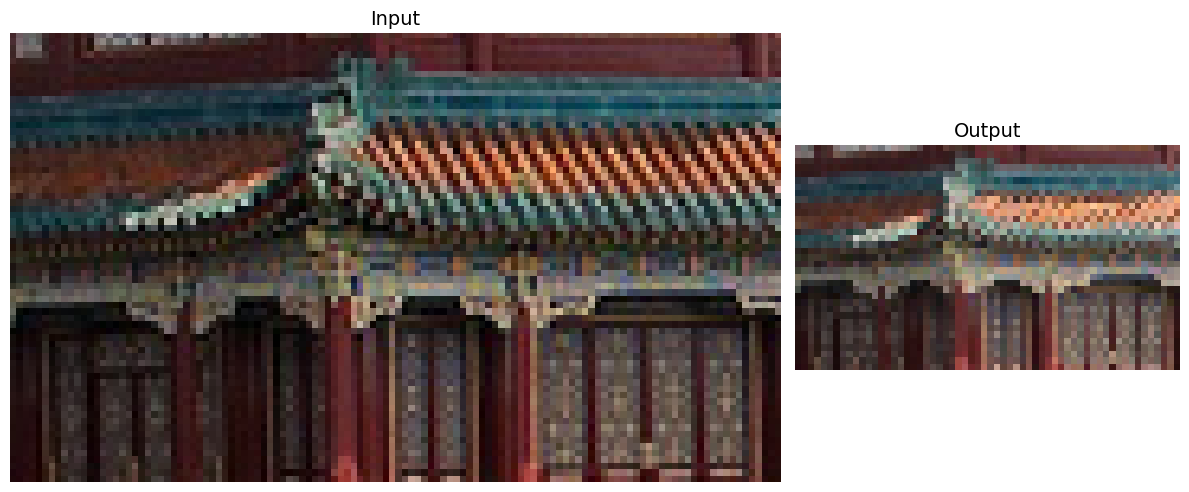

In [91]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
save_fig("china_max_pooling")
plt.show()

## Running a CNN with MNIST dataset

In [105]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [110]:
from functools import partial

DefaultConv2D = partial(tf.keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = tf.keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=5, input_shape=[28, 28, 1]),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=32),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=10, activation='softmax'),
])

In [111]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=3, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Epoch 1/5
1719/1719 [==============================] - 24s 14ms/step - loss: 0.1860 - accuracy: 0.9453 - val_loss: 0.0606 - val_accuracy: 0.9838
Epoch 2/5
1719/1719 [==============================] - 24s 14ms/step - loss: 0.0596 - accuracy: 0.9818 - val_loss: 0.0558 - val_accuracy: 0.9858
Epoch 3/5
1719/1719 [==============================] - 24s 14ms/step - loss: 0.0431 - accuracy: 0.9864 - val_loss: 0.0466 - val_accuracy: 0.9892
Epoch 4/5
1719/1719 [==============================] - 24s 14ms/step - loss: 0.0353 - accuracy: 0.9889 - val_loss: 0.0484 - val_accuracy: 0.9890
Epoch 5/5
1/1 [==============================] - 0s 78ms/step


**_Exercise 5_**
1. Visualise and/or draw on your paper this convolutional neural net to figure out its current structure.
2. Tune the model such that the accuracy is acceptably good, the required memory is low, and the training time is small.

## Overfitting

'With 4 parameters I can fit an elephant and with 5 I can make him wiggle his trunk.' John von Neumann, _cited by Enrico Fermi in Nature 427_

Do not forget that an overfitted model will not perform well in the real world. It is therefore important for you to know how to prevent this issue with neural networks in general.

**_Exercise 6_**

1. On deep net and/or CNN for MNIST above, implement one or a combination of the regularisation techniques listed below. Observe any difference or change in performance during training:
   
   1.1. $l_1$ or $l_2$ regularisation, by correctly specifying TensorFlow parameters. (_Hint_: Look for `tf.keras.regularizers` in the online documentation)
   
   1.2. Dropout, where each neuron has a probability of being turned off at each epoch in training phase (_Hint_: apply `tf.keras.layers.Dropout()` (See: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) to the input layer and/or any hidden layer's output, but NOT the output of the output layer. You could also use `tf.keras.layers.AlphaDropout()` (See: https://www.tensorflow.org/api_docs/python/tf/keras/layers/AlphaDropout).)
   

## Summary
We have implemented DNN and CNN using tensorflow. There are still a lot of nuances that you can work with. This is just an overview to help you get started and build upon. Please refer to relevant Chapters in the refernce textbook to know more.

## Sidenote
There are many high level APIs that you can use to quickly create and deploy Machine Learning prototypes. They are very useful but it is difficult to make non-standard changes to their implementation of Machine Learning models. If you are interested, have a look on the following:
- Estimators: <a href="https://www.tensorflow.org/guide/estimators">https://www.tensorflow.org/guide/estimators</a>
- Keras: <a href="https://www.tensorflow.org/guide/keras">https://www.tensorflow.org/guide/keras</a>
- Eager execution: <a href="https://www.tensorflow.org/guide/eager">https://www.tensorflow.org/guide/eager</a>

## Reference
Aurélien Géron, _Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems_.